In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
cols_to_drop = ['FALLA','FECHA','REP','CAEX','SISTEMA']
residuals = []

df = pd.read_excel('.\data.xlsx')
data = df[df.SISTEMA =='Vvolts'] # Select the caex sistem
data_to_eval = data.drop(cols_to_drop,axis=1).reset_index(drop=True)

# Modelos de Cox B1-B2

In [3]:
# Model B1 
# ===========================================
cph1 = CoxPHFitter().fit(data[['TBF']], duration_col='TBF')

# Model B2
# ===========================================
cph2 = CoxPHFitter().fit(data_to_eval, duration_col='TBF')

### Test para la hipótesis de riesgos proporcionales

In [66]:
results = proportional_hazard_test(cph2, data_to_eval, time_transform='km')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = km
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1615 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic    p  -log2(p)
Consumo                                  0.79 0.37      1.42
Estanque_remanente                       4.15 0.04      4.59
Horas_desde_ultima_mantencion            0.24 0.63      0.68
Horometro                                0.43 0.51      0.96
Litros_ciclos                            6.50 0.01      6.53
Media_Dist_lleno                         0.20 0.66      0.61
Media_Dist_vacio                         7.50 0.01      7.34
Media_Disteq_lleno_2                     0.17 0.68      0.56
Media_Disteq_vacio_2                     6.74 0.01      6.73
Media_tiempo_viajelleno                  0.45 0.50      0.99
Media_tiempo_viajevacio                  0.28 0.60      0.74
Pendiente_lleno                          0.03 0.87      0.20
Pendiente_vacio                          0.64 0.42      1.24
TiempoCiclo                              0.92 0.34      1.57
Tiempoviaje_lleno                        3.20 0.07      3.76
Tiempoviaje_vacio                        2.74 0.10      3.35
TonelajeProm                             0.09 0.76      0.39
Velocidad_lleno                          5.06 0.02      5.36
Velocidad_vacio                          2.31 0.13      2.96
cant_fase10                              1.30 0.25      1.98
cant_fase11                              0.77 0.38      1.39
cant_fase12                              0.77 0.38      1.40
cant_fase13                              0.28 0.60      0.75
cant_fase9                               0.43 0.51      0.96
ciclos_operador_1                        0.01 0.94      0.09
ciclos_operador_2                        0.23 0.63      0.66
conteo_demoras                           0.38 0.54      0.90
descargas                                0.00 0.96      0.06
dist_lleno                               0.09 0.76      0.40
dist_vacio                               4.00 0.05      4.46
disteq_lleno                             2.91 0.09      3.50
disteq_vacio                             2.19 0.14      2.85
esperas_encendido                        1.06 0.30      1.73
hrs_efectivas                            0.21 0.65      0.63
tiempo_carga_combustible                 0.59 0.44      1.17
tiempo_cola                              0.25 0.62      0.69
tiempo_espera_combustible                0.81 0.37      1.44
tiempo_traslado_combustible              1.00 0.32      1.66
tonelaje_bajo_280                        0.05 0.83      0.27
tonelaje_sobre_320                       0.71 0.40      1.32
tonelaje_total                           0.05 0.82      0.29

### Modelos con variables que aprueban/ no aprueban la hipótesis de riesgos proporcionales

In [67]:
# Model B3 
# ===========================================================================================
s = results.summary
cph3 = CoxPHFitter().fit(data[['TBF']+list(s[s.p<0.05].reset_index()['index'])], duration_col='TBF')

# Model B4
# ===========================================================================================
cph4 = CoxPHFitter().fit(data_to_eval.drop(list(s[s.p<0.05].reset_index()['index']),axis=1), duration_col='TBF')

<AxesSubplot:title={'center':'MODELO B3'}, xlabel='log(HR) (95% CI)'>

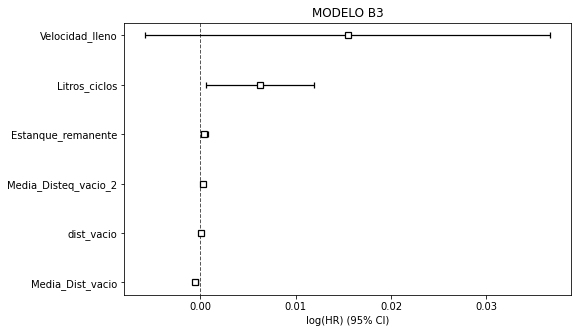

In [68]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('MODELO B3')
cph3.plot(ax=ax)

<AxesSubplot:title={'center':'MODELO B4'}, xlabel='log(HR) (95% CI)'>

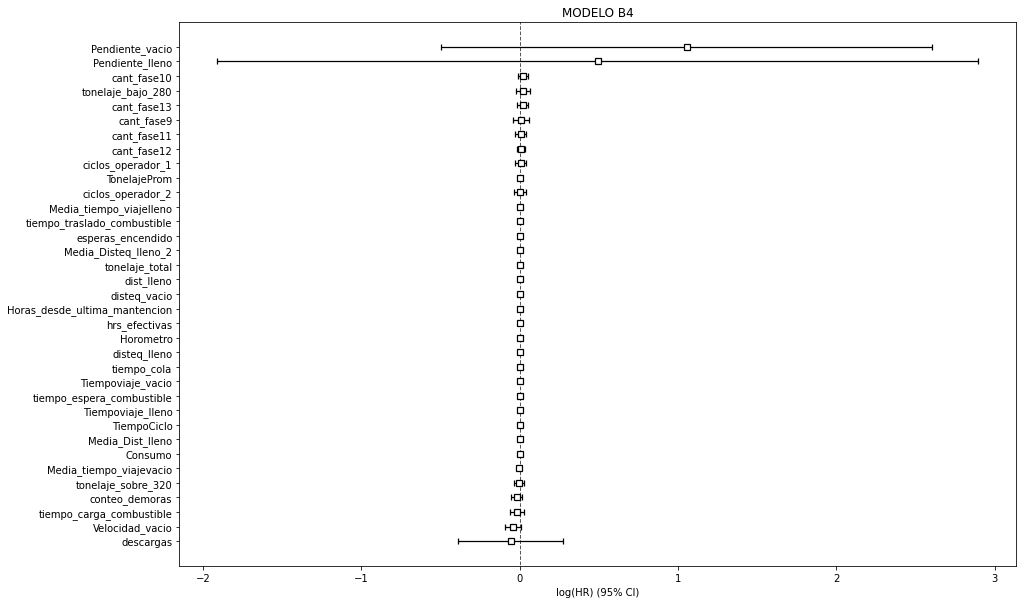

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.title('MODELO B4')
cph4.plot(ax=ax)

### Se comparan las tasas de falla base acumuladas
$$ \Lambda_0(t) = \int_0^t \lambda_0(t)$$

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1615 total observations, 0 right-censored observations>
   number of observations = 1615
number of events observed = 1615
           log-likelihood = -13613.85
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 1508.49      63.34          1384.34          1632.64
rho_       0.62       0.01             0.60             0.65

          cmp to      z      p   -log2(p)
lambda_     1.00  23.80 <0.005     413.46
rho_        1.00 -30.20 <0.005     663.19
---
AIC = 27231.69

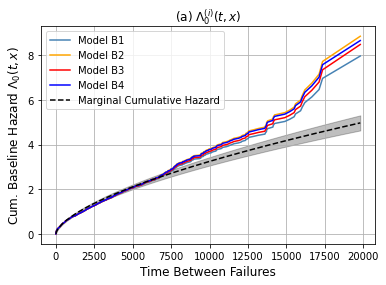

In [70]:
from lifelines import WeibullFitter
wf = WeibullFitter().fit(list(data.TBF))

fig, ax = plt.subplots()
wf.print_summary()

cph1.baseline_cumulative_hazard_.plot(ax=ax,color='steelblue',label='Cumulative Hazard Model B1')
cph2.baseline_cumulative_hazard_.plot(ax=ax,color='orange',label='Cumulative Hazard Model B2')
cph3.baseline_cumulative_hazard_.plot(ax=ax,color='red',label='Cumulative Hazard Model B3')
cph4.baseline_cumulative_hazard_.plot(ax=ax,color='blue',label='Cumulative Hazard Model B4')

wf.plot_cumulative_hazard(ax=ax,color='Black',linestyle='--',label='Marginal Cumulative Hazard')

plt.legend(['Model B1','Model B2','Model B3','Model B4',
            'Marginal Cumulative Hazard'], loc ="best")

plt.title(r'(a) $ \Lambda_0^{(i)}(t,x)$')

plt.ylabel(r"Cum. Baseline Hazard $ \Lambda_0(t,x)$", fontsize=12)
plt.xlabel("Time Between Failures", fontsize=12)
plt.grid('on')
plt.show()

### Se comparan los resultados de las regresiones en los 4 modelos

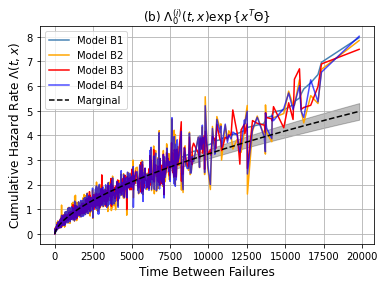

In [24]:
def wf_ch(x,a,b):
    return (x/a)**(b)

cph2_CH = cph2.baseline_cumulative_hazard_.reset_index()
cph3_CH = cph3.baseline_cumulative_hazard_.reset_index()
cph4_CH = cph4.baseline_cumulative_hazard_.reset_index()

tbfs = []
model_b2 = []
model_b3 = []
model_b4 = []

for i in range(len(data_to_eval)):
    tbf = data_to_eval.loc[i,'TBF']
    xi  = data_to_eval.drop('TBF',axis=1).loc[i,:]
    xi3 = data_to_eval[list(s[s.p<0.05].reset_index()['index'])].loc[i,:]
    xi4 = data_to_eval.drop(list(s[s.p<0.05].reset_index()['index']),axis=1).drop('TBF',axis=1).loc[i,:]
    
    cph2_params = pd.DataFrame(cph2.params_).reset_index().coef
    cph3_params = pd.DataFrame(cph3.params_).reset_index().coef
    cph4_params = pd.DataFrame(cph4.params_).reset_index().coef

    cox_exp2 = np.exp(np.dot(xi,cph2_params))
    cox_exp3 = np.exp(np.dot(xi3,cph3_params))
    cox_exp4 = np.exp(np.dot(xi4,cph4_params))
    
    l2 = cph2_CH[cph2_CH['index']==tbf].reset_index(drop=True).loc[0,'baseline cumulative hazard']
    l3 = cph3_CH[cph3_CH['index']==tbf].reset_index(drop=True).loc[0,'baseline cumulative hazard']
    l4 = cph4_CH[cph4_CH['index']==tbf].reset_index(drop=True).loc[0,'baseline cumulative hazard']
    
    cox2 = l2*cox_exp2
    cox3 = l3*cox_exp3
    cox4 = l4*cox_exp4
    
    model_b2.append(cox2)
    model_b3.append(cox3)
    model_b4.append(cox4)
    tbfs.append(tbf)
    
COX = pd.DataFrame({'Time Between Failures':tbfs,'MODEL B2':model_b2,'MODEL B3':model_b3,'MODEL B4':model_b4})
COX = COX.sort_values(by='Time Between Failures').set_index('Time Between Failures')

COX['MARGINAL CH'] = [wf_ch(x,wf.lambda_,wf.rho_)  for x in COX.reset_index()['Time Between Failures']]

COX = (COX -COX.std())/(COX.mean())
COX=COX-COX.min()

fig, ax = plt.subplots()

cph1.baseline_cumulative_hazard_.plot(ax=ax,color='steelblue',label='Model B1')

COX[['MODEL B2']].plot(ax=ax,color='orange')
COX[['MODEL B3']].plot(ax=ax,color='red')
COX[['MODEL B4']].plot(ax=ax,color='blue',alpha=0.7)

wf.plot_cumulative_hazard(ax=ax,color='Black',linestyle='--',label='Marginal Cumulative Hazard')

plt.legend(['Model B1','Model B2','Model B3','Model B4','Marginal'], loc ="best")

plt.title('(b) $ \Lambda_0^{(i)}(t,x)\exp\{x^T \Theta \}$')
plt.ylabel(r"Cumulative Hazard Rate $\Lambda(t,x)$", fontsize=12)
plt.xlabel("Time Between Failures", fontsize=12)
plt.grid('on')
plt.show()

## qq-plots

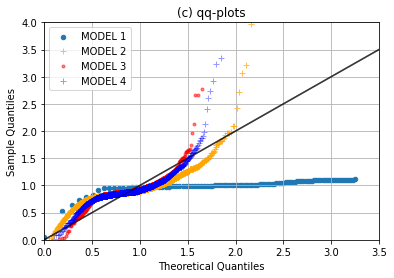

In [28]:
from scipy import stats
import statsmodels.api as sm

residuals1 = []
residuals2 = []
residuals3 = []
residuals4 = []

cph1_res = cph1.baseline_cumulative_hazard_.reset_index()
res_cox = COX.reset_index()
for i in range(len(res_cox)):
    tbf = res_cox.loc[i,'Time Between Failures']
    y0 = cph1_res[cph1_res['index']==tbf].loc[i,'baseline cumulative hazard']
    y = res_cox.loc[i,'MARGINAL CH']
    
    # Residuals
    y1 = y - y0
    y2 = y - res_cox.loc[i,'MODEL B2']
    y3 = y - res_cox.loc[i,'MODEL B3']
    y4 = y - res_cox.loc[i,'MODEL B4']
    
    residuals1.append(y1)
    residuals2.append(y2)
    residuals3.append(y3)
    residuals4.append(y4)


qq1 = [ np.exp(np.quantile(residuals1,i)) for i in np.linspace(0,1,100)]
qq2 = [ np.exp(np.quantile(residuals2,i)) for i in np.linspace(0,1,100)]
qq3 = [ np.exp(np.quantile(residuals3,i)) for i in np.linspace(0,1,100)]
qq4 = [ np.exp(np.quantile(residuals4,i)) for i in np.linspace(0,1,100)]

th_qq = [np.quantile([wf_ch(x,wf.lambda_,wf.rho_)  for x in range(10000)],i) for i in np.linspace(0,1,100)]
df_qqplot = pd.DataFrame({'Theorical Quantiles':th_qq,'qq_index':th_qq,
                          'MODEL 1':qq1,'MODEL 2':qq2,'MODEL 3':qq3,'MODEL 4':qq4}).set_index('Theorical Quantiles')

fig, ax = plt.subplots()
df_qqplot[['qq_index','MODEL 1']].plot.scatter(ax=ax,x='qq_index',y='MODEL 1',label='MODEL 1')

pp = sm.ProbPlot(np.exp(np.array(residuals2)), dist=stats.weibull_min,fit=True)
qq = pp.qqplot(marker='+', markerfacecolor='orange', markeredgecolor='orange', alpha=0.7,ax=ax,label='MODEL 2')
sm.qqline(qq.axes[0], line='45', fmt='black', alpha=0.4,label=None)

pp = sm.ProbPlot(np.exp(np.array(residuals3)), dist=stats.weibull_min,fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='red', markeredgecolor='red', alpha=0.5,ax=ax,label='MODEL 3')
sm.qqline(qq.axes[0], line='45', fmt='black', alpha=0.4,label=None)

pp = sm.ProbPlot(np.exp(np.array(residuals4)), dist=stats.weibull_min,fit=True)
qq = pp.qqplot(marker='+', markerfacecolor='blue', markeredgecolor='blue', alpha=0.4,ax=ax,label='MODEL 4')
sm.qqline(qq.axes[0], line='45', fmt='black', alpha=0.4,label=None)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_ylim(0,4)
ax.set_xlim(0,3.5)
plt.title('(c) qq-plots')
plt.grid('on')
plt.show()

### Regularización $L_1$

#### La librería lifelines permite incorporar una penalización  $L_1$ (Lasso) , la cual consiste en resolver 

$$\max_{\boldsymbol{\theta} \in \mathbb{R}^N} F(\boldsymbol{\theta}):= \sum_i l(\boldsymbol{\theta},\sigma,\textbf{x}_i) + \lambda ||\boldsymbol{\theta}||_1$$

###  ¿Cuál es el mejor valor de $\lambda$ ?

In [4]:
lambdas = []
AICs = []
STDs = []
for p in np.linspace(1e-4, 0.2, 1000):
    
    dfs = np.array_split(data_to_eval,5)
    df1 = pd.concat([dfs[1],dfs[2],dfs[3],dfs[4]])
    df2 = pd.concat([dfs[0],dfs[2],dfs[3],dfs[4]])                
    df3 = pd.concat([dfs[0],dfs[1],dfs[3],dfs[4]]) 
    df4 = pd.concat([dfs[0],dfs[1],dfs[2],dfs[4]]) 
    df5 = pd.concat([dfs[0],dfs[1],dfs[2],dfs[3]])
    
    try:
        mean_aics = []
        for df in [df1,df2,df3,df4,df5]:
            # Filter variables using lasso
            # ===============================================================================
            cph = CoxPHFitter(l1_ratio=1., penalizer=p).fit(df, duration_col='TBF')
            aux_params = pd.DataFrame(cph.params_).reset_index()
            coef_selection = list(aux_params[aux_params.coef>1e-10].covariate)
            #================================================================================
            # Cox model with the selected variables
            # ===============================================================================
            new_cph = CoxPHFitter().fit(data_to_eval[['TBF']+coef_selection], duration_col='TBF')
            # ================================================================================
            # Get the AIC
            # =========================
            mean_aics.append(new_cph.AIC_partial_)
        
        STDs.append(np.std(mean_aics))
        AICs.append(np.mean(mean_aics))
        lambdas.append(p)
    except:
        continue

In [6]:
aic_df = pd.DataFrame({r'$\lambda$':lambdas,'AIC':AICs,r'$\sigma$':STDs}).set_index(r'$\lambda$')
aic_df['lower'] = aic_df['AIC'] - aic_df[r'$\sigma$']
aic_df['upper'] = aic_df['AIC'] + aic_df[r'$\sigma$']

The minimum is reached in λ = 0.054527227227227235


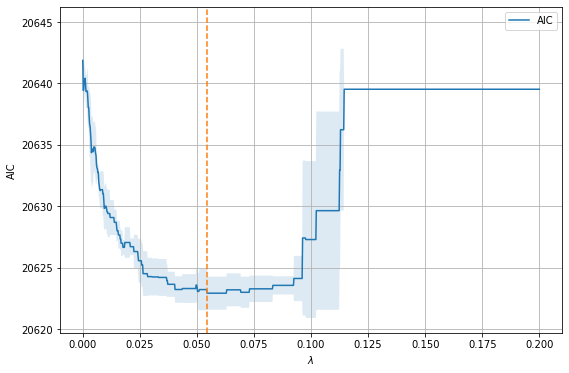

In [24]:
fig, ax = plt.subplots(figsize=(9, 6))

aic_df[['AIC']].plot(ax=ax)
ax.fill_between(aic_df.index, aic_df.lower, aic_df.upper, alpha=.15)

lmd_to_min = aic_df[aic_df.AIC == aic_df.AIC.min()].index[0]
print('The minimum is reached in λ =', lmd_to_min)

ax.set_ylabel("AIC")
ax.set_xlabel("$\lambda$")
ax.axvline(lmd_to_min, c="C1",linestyle='--')
ax.grid(True)

In [26]:
mean_aics

[20621.652017458895,
 20622.32108209815,
 20621.652017458895,
 20624.06909601417,
 20624.9720229022]

### Se toma entonces $\lambda\approx 0.05453$ 

In [ ]:
cx = CoxPHFitter(l1_ratio=1., penalizer=lmd_to_min).fit(data_to_eval, duration_col='TBF')

### Se ajusta el modelo con las variables filtradas por la regularización Lasso

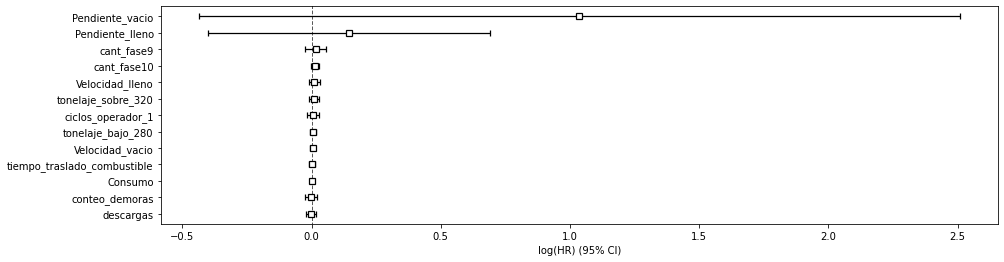

In [17]:
res = pd.DataFrame(cx.params_).reset_index()
lasso_variables = res[res.coef>1e-10].covariate.to_list()
cph5 = CoxPHFitter().fit(data[['TBF']+lasso_variables], duration_col='TBF')

fig, ax = plt.subplots(figsize = (15,4))
cph5.plot(ax=ax)
plt.yticks(fontsize=10)
plt.show()

## $\lambda$ óptimo para cada sistema en cuestión

In [ ]:
cols_to_drop = ['FALLA','FECHA','REP','CAEX','SISTEMA']
residuals = []
aic_dfs = []
optimals_aic = []
data = pd.read_excel('.\data.xlsx')
for s in data.SISTEMA.unique():

    data_caex = data[data.SISTEMA ==s] # Select the caex sistem
    data_to_eval = data_caex.drop(cols_to_drop,axis=1).reset_index(drop=True)
    
    lambdas = []
    AICs = []
    STDs = []
    for p in np.linspace(1e-4, 0.2, 1000):

        dfs = np.array_split(data_to_eval,5)
        df1 = pd.concat([dfs[1],dfs[2],dfs[3],dfs[4]])
        df2 = pd.concat([dfs[0],dfs[2],dfs[3],dfs[4]])                
        df3 = pd.concat([dfs[0],dfs[1],dfs[3],dfs[4]]) 
        df4 = pd.concat([dfs[0],dfs[1],dfs[2],dfs[4]]) 
        df5 = pd.concat([dfs[0],dfs[1],dfs[2],dfs[3]])

        try:
            mean_aics = []
            for df in [df1,df2,df3,df4,df5]:
                # Filter variables using lasso
                # ===============================================================================
                cph = CoxPHFitter(l1_ratio=1., penalizer=p).fit(df, duration_col='TBF')
                aux_params = pd.DataFrame(cph.params_).reset_index()
                coef_selection = list(aux_params[aux_params.coef>1e-5].covariate)
                #================================================================================
                # Cox model with the selected variables
                # ===============================================================================
                new_cph = CoxPHFitter().fit(data_to_eval[['TBF']+coef_selection], duration_col='TBF')
                # ================================================================================
                # Get the AIC
                # =========================
                mean_aics.append(new_cph.AIC_partial_)

            STDs.append(np.std(mean_aics))
            AICs.append(np.mean(mean_aics))
            lambdas.append(p)
        except:
            continue
            
    aic_df = pd.DataFrame({r'$\lambda$':lambdas,'AIC':AICs,r'$\sigma$':STDs}).set_index(r'$\lambda$')
    aic_df['lower'] = aic_df['AIC'] - aic_df[r'$\sigma$']
    aic_df['upper'] = aic_df['AIC'] + aic_df[r'$\sigma$']
    
    aic_df['SISTEMA'] = [s]*len(aic_df)
    
    aic_dfs.append(aic_df)
    
    optimals_aic.append(aic_df[aic_df.AIC==aic_df.AIC.min()])

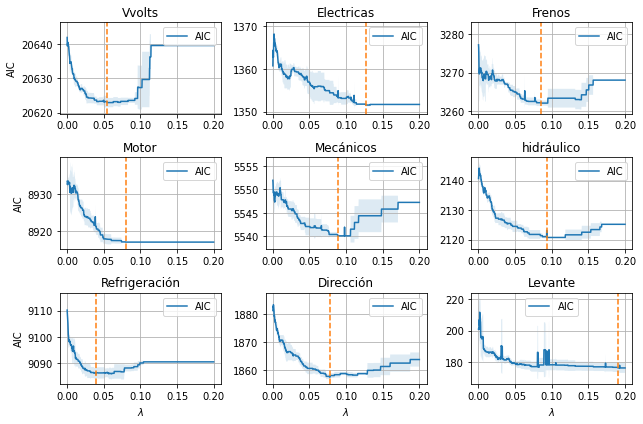

In [24]:
fig, ax = plt.subplots(3,3,figsize=(9, 6))
ci = [0,0,0,1,1,1,2,2,2]
cj =0
for a in aic_dfs:
    i = ci[cj]
    j = cj%3
    a[['AIC']].plot(ax=ax[i][j])
    ax[i][j].fill_between(a.index, a.lower, a.upper, alpha=.15)
    lmd_to_min = a[a.AIC == a.AIC.min()].index[0]
    ax[i][j].axvline(lmd_to_min, c="C1",linestyle='--')
    
    ax[i][j].set_title(a.SISTEMA.unique()[0])
    
    if j == 0:
        ax[i][j].set_ylabel("AIC")
    else:
        ax[i][j].set_ylabel("")
    
    if i==2:
        ax[i][j].set_xlabel("$\lambda$")
    else:
        ax[i][j].set_xlabel("")
        #ax[i][j].tick_params(axis='x',which='both',  bottom=False,labelbottom=False)
        
        
    ax[i][j].grid(True)
    cj+=1
fig.tight_layout()

In [29]:
pd.concat(optimals_aic).drop_duplicates('SISTEMA',keep='first')

,AIC,$\sigma$,lower,upper,SISTEMA
$\lambda$,,,,,
0.054527,20622.933247,1.349415,20621.583832,20624.282662,Vvolts
0.127164,1351.547713,0.294470,1351.253244,1351.842183,Electricas
0.085343,3262.089654,0.665714,3261.423940,3262.755367,Frenos
0.079940,8916.961124,0.000000,8916.961124,8916.961124,Motor
0.088744,5540.085372,0.000000,5540.085372,5540.085372,Mecánicos
0.093747,2120.702366,0.000000,2120.702366,2120.702366,hidráulico
0.039320,9085.895173,2.120791,9083.774382,9088.015964,Refrigeración
0.077539,1857.534082,0.710441,1856.823641,1858.244524,Dirección
0.190595,176.449390,3.151118,173.298272,179.600508,Levante
